In [11]:
# Standard library imports
import warnings

# Third-party library imports
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_absolute_error, classification_report
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.pipeline import make_pipeline
from xgboost import XGBRegressor
from sklearn.metrics import r2_score

# Suppress warnings
warnings.filterwarnings('ignore')

In [42]:
df

,ratingsymbol,audit
0,BBB+,Regulatory Accounting -- Impact of Rate Regula...
1,BB-,Valuation of the allowance for loan losses. De...
2,AA-,Income taxes - Unrecognized tax benefits. Desc...
3,A-,Estimate of the future policy benefits for ter...
4,BB-,Impairment Assessment - Goodwill In the Energy...
...,...,...
627,BB+,Recoverability of goodwill for the Canadian an...
628,B+,Valuation of Inventories. As described in Note...
629,B-,Goodwill and trade name indefinite-lived intan...
630,B+,Empire wholesale fuel supply contracts. As des...


### 21 credit ratings from AAA to D
- typical rating scales used by major credit rating agencies like Standard & Poor's, Moody's, and Fitch

In [19]:
rating_mapping = {
    'AAA': 21, 'AA+': 20, 'AA': 19, 'AA-': 18, 'A+': 17, 'A': 16, 'A-': 15,
    'BBB+': 14, 'BBB': 13, 'BBB-': 12, 'BB+': 11, 'BB': 10, 'BB-': 9, 'B+': 8, 'B': 7, 'B-': 6,
    'CCC+': 5, 'CCC': 4, 'CCC-': 3, 'CC': 2, 'C': 1,
    'D': 0,
}

df['ratingsymbol'] = df['ratingsymbol'].map(rating_mapping)

In [20]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['audit'])
y = df[['ratingsymbol']]

# NLP
- (Project) To build a NLP model from scratch (without using pretrained model) to predict credit ratings based on the auditor's opinions
- Data processing
    - Tokenization: break down text into smaller units (words or phrases)
    - Removing stopwords : remove words with little meaning ("the", "is")
    - Lemmatization/Stemming : reduce words to their base or root form
- Feature Extraction: convert text into numerical features
    - Bag of Words: Counts the frequency of words
    - TF-IDF (Term Frequency-Inverse Document Frequency): Weighs the word frequencies by how rare they are in the data
-  Select ML model:
    - XGBoost
        - A type of GBM
        - It is known for high performance in a variety of tasks, including text classification
- Train model
- Performance metrics
    - accuracy, precision, recall, etc

# TF-IDF (Term Frequency-Inverse Document Frequency)
- transform text data into numerical format
- Term Frequency (TF):
    - for each document
        - a more frequency term is more important in understanding the text
        - TF of a term = frequency of the term / total num of terms
- Inverse Document Frequency (IDF)
    - to compare across documents
        - IDF measure how important is a term across documents
        - = logarithmically scaled inverse of the number of documents that contain the term t. This helps to attenuate the effect of terms that occur very frequently across many documents and are thus less informative.
- TF-IDF term = TF term multiple by IDF term
- **High TF-IDF score = a term is frequent in a given document but not across documents, emphasizing its uniqueness and potential importance in the given document**
- Low TD-IDF score: 
    - either:
    - (1) the term appears in many documents across the collection (thus is common and potentially less informative) 
    - or (2) the term is rare in the specific document and in all documents
- sklearn's **TfidfVectorizer**
    - Input all the documents
    - Calc TD-IDF score for each term in all docuemnts
    
# GBM v.s. Random Forest
- Both are ensemble methods that use decision trees
- Bagging (Random Forest): Involves building multiple decision trees independently and combining their predictions through averaging or voting. The individual trees are built from bootstrap samples (random samples with replacement) of the training data.
- Boosting (GBM): Involves building trees sequentially, where each tree attempts to correct the errors of the previous ones. It combines these weak learners to form a strong predictive model. GBMs adjust the weight of each tree according to its performance, and trees are built focusing on errors made in previous stages.
    
# XGBoost
- eXtreme Gradient Boosting
- It is an advanced version of GBM, 
    - Pros:
        - Improved speed and accuracy
        - Regularization: Helps in reducing overfitting.
        - Tree Pruning: Uses depth-first approach, which is more effective than traditional level-wise approach.
            - Depth-First Tree Pruning: grow tree to max depth, then prune tree backward, allowing moel to eliminate unncessary brainches earlier
            - Level-Wise Approach (Traditional GBM): each level of nodes is expanded before moving to the next level, may lead to larger tree than necessary 
        - Built-in Cross-Validation: At each iteration.
       
        
# eval_metric='mlogloss'
- multiclass logloss
- a loss function during training, useful for classification problems with more than two classes
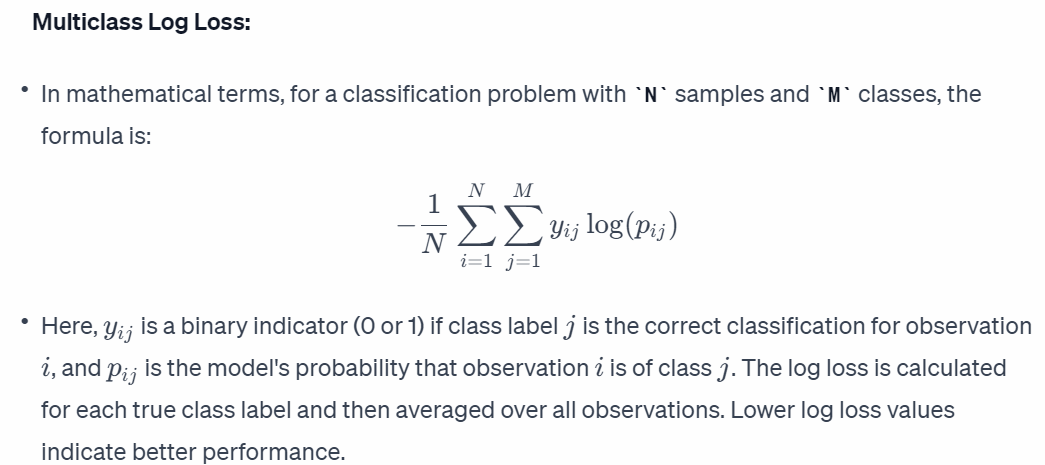

# stratified k-fold cross-validation
- better than train_test_split
- deals with sparse and imbalanced data
- solving 'imbalanced' data --> use stratified version of k-fold cross-validation, which will maintain the ratio of the classes in each fold as it is in the full dataset

# Training method
- Because of sparse data, I train XGB model on 100% of data
- But I want a guage of model performance on my data. So I use K-Folds Cross-Validation to calculate the average MAE

In [21]:
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
# n_splits=10 --> 10 iterations, each iteration: 1 fold test, 9 folds train. Always only 1 fold testing
# shuffle=True --> randomly split into folds for each iteration

mae_scores = []

for train_index, test_index in kf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = XGBRegressor()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    y_pred_rounded = np.round(y_pred)
    y_pred_rounded = np.clip(y_pred_rounded, 0,21)
    
    mae_scores.append(mean_absolute_error(y_test, y_pred_rounded))

average_mae = np.mean(mae_scores)
print(f"Average MAE: {average_mae}")

Average MAE: 2.4003224206349207


In [22]:
# Split the dataset into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the model
model = XGBRegressor(
    max_depth=10,           # max depth of tree. Higher number increase performance but may overfit
    n_estimators=200,       # no of gradient boost trees. Higher number increase performance but may overfit
    learning_rate=0.05,     # Higher learning rate --> faster convergence, less time. But lower performance
    gamma=0.1,              # If the splitting of a node doesn't result in a loss reduction greater than gamma, the node won't split.
    min_child_weight=1,     # Higher value to prevent model from learning only from specific data
    subsample=0.8,          # =80% means each tree is trainied on a 80% random subset of rows in training data. 
    colsample_bytree=0.8    # =80% means only 80% of random x varaible is used for training of each tree
)

# generally...
# max_depth:
# Low: 1-3 (for simple problems or to prevent overfitting)
# High: 10-15 (for complex problems, but may lead to overfitting)

# n_estimators:
# Low: 50-100 (quick training, but may underfit if too low)
# High: 200-1000 (can capture complex patterns, risk of overfitting)

# learning_rate:
# Low: 0.01-0.05 (slow learning, requires more trees, but often better generalization)
# High: 0.1-0.3 (faster learning, but can overshoot optimal performance)

# gamma:
# Low: 0-0.1 (little to no regularization, more complex models)
# High: 1-5 (strong regularization, conservative models)

# min_child_weight:
# Low: 1 (minimal restriction on leaf nodes)
# High: 10-20 (higher values can prevent overfitting to noise)

# subsample:
# Low: 0.5-0.8 (can help prevent overfitting)
# High: 0.8-1.0 (1.0 means using all data, less randomness)

# colsample_bytree:
# Low: 0.5-0.8 (can help prevent overfitting, adds randomness)
# High: 0.8-1.0 (1.0 means using all features)

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Round and clip predictions as in your original code
y_pred_rounded = np.round(y_pred)
y_pred_rounded = np.clip(y_pred_rounded, 0, 21)

In [23]:
# Predict on the test set
y_pred = model.predict(X_test)

# Round predictions and actual values to the nearest integer
y_pred_rounded = np.round(y_pred)
y_test_rounded = np.round(y_test.to_numpy())  # Convert y_test to numpy array if it's not already

# Calculate the number of exact matches
exact_matches = np.sum(y_pred_rounded == y_test_rounded)

# Calculate accuracy
accuracy = exact_matches / len(y_test)
print(f"Accuracy: {accuracy:.2f} %")


Accuracy: 15.03 %


In [24]:
# Predict on the test set
y_pred = model.predict(X_test)

# Calculate R-squared
r_squared = r2_score(y_test, y_pred)
print(f"R-squared: {r_squared}")


R-squared: 0.13728227228220524


In [25]:
combined_array = np.column_stack((y_test_rounded, y_pred_rounded))

In [26]:
df2 = pd.DataFrame(combined_array)

In [27]:
df2 = df2.rename(columns={0:'y_test_rounded'})
df2 = df2.rename(columns={1:'y_pred_rounded'})

<Axes: >

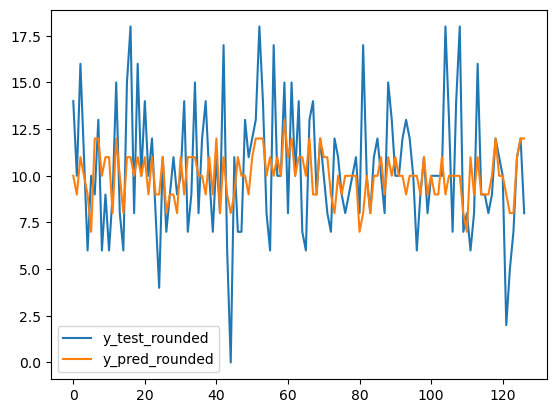

In [28]:
df2[['y_test_rounded','y_pred_rounded']].plot()